<a href="https://colab.research.google.com/github/khs5696/AI504/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import copy
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import Image

Hyperparameter

In [2]:
batch_size = 100
learning_rate = 1e-3
epochs = 15

Dataset

In [3]:
train = datasets.MNIST(root='./', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
test = datasets.MNIST(root='./', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
train, valid = torch.utils.data.random_split(train, [50000, 10000])

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)

Model

In [4]:
# https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
# !wget -q https://www.dropbox.com/s/lmpjzzkqhk7d408/vae_gaussian.png
# Image("vae_gaussian.png")

In [5]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    # Probabilistic encoder
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.Tanh(),
    )

    self.fc_mu = nn.Linear(256, 10)
    self.fc_var = nn.Linear(256, 10)

    # Probabilistic decoder
    self.decoder = nn.Sequential(
        nn.Linear(10, 256),
        nn.Tanh(),
        nn.Linear(256, 28*28),
        nn.Sigmoid()
    )

  def encode(self, x):
    h = self.encoder(x)
    mu = self.fc_mu(h)
    var = self.fc_var(h)
    return mu, var

  def reparameterize(self, mu, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    # batch_size = x.size(0)
    mu, var = self.encode(x.reshape(batch_size, -1))
    latent = self.reparameterize(mu, var)
    output = self.decoder(latent)
    return output, mu, var

Train

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
BCE = torch.nn.BCELoss(reduction='sum')   # Binary Cross Entropy
def loss_func(x, recon_x, mu, log_var):
    BCE_loss = BCE(recon_x, x.view(-1, 784))
    KLD_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE_loss + KLD_loss

In [7]:
def train(model, criterion, epochs):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_val_loss = 100000000

  train_history = []
  test_history = []

  for epoch in range(epochs):
    print("-"*10)
    print("Epoch {}/{}".format(epoch+1, epochs))
    # Train
    train_loss = 0.0
    model.train()
    for data, label in train_dataloader:
      data = data.to(device)    # (batch_size, 1, 28, 28)
      with torch.set_grad_enabled(True):
        output, mu, var = model(data) # (batch_size, 784)
        optimizer.zero_grad()
        loss = criterion(data, output, mu, var)
        loss.backward()
        optimizer.step()
      train_loss += loss.item()
    epoch_loss = train_loss / len(train_dataloader.dataset)
    train_history.append(epoch_loss)
    print('Train Loss: {:.4f}'.format(epoch_loss))

    # Validation
    val_loss = 0.0
    model.eval()
    for data, label in valid_dataloader:
      data = data.to(device)
      with torch.set_grad_enabled(False):
        output, mu, var = model(data)
        loss = criterion(data, output, mu, var)
        val_loss += loss.item()
    epoch_loss = val_loss / len(valid_dataloader.dataset)
    test_history.append(epoch_loss)
    print('Valid Loss: {:.4f}'.format(epoch_loss))

    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

  # load best model weights
  print('Best val Loss: {:4f}'.format(best_val_loss))
  model.load_state_dict(best_model_wts)
  return model, train_history, test_history

best_model, train_history, test_history = train(model, loss_func, epochs=epochs)

----------
Epoch 1/15
Train Loss: 170.5802
Valid Loss: 141.0561
----------
Epoch 2/15
Train Loss: 136.4912
Valid Loss: 132.1938
----------
Epoch 3/15
Train Loss: 129.6862
Valid Loss: 127.0063
----------
Epoch 4/15
Train Loss: 125.3484
Valid Loss: 123.5517
----------
Epoch 5/15
Train Loss: 122.3135
Valid Loss: 120.9128
----------
Epoch 6/15
Train Loss: 120.1057
Valid Loss: 119.3828
----------
Epoch 7/15
Train Loss: 118.3891
Valid Loss: 117.5721
----------
Epoch 8/15
Train Loss: 116.9876
Valid Loss: 116.4217
----------
Epoch 9/15
Train Loss: 115.8086
Valid Loss: 115.5542
----------
Epoch 10/15
Train Loss: 114.9369
Valid Loss: 114.7220
----------
Epoch 11/15
Train Loss: 114.2048
Valid Loss: 114.2687
----------
Epoch 12/15
Train Loss: 113.5387
Valid Loss: 113.4616
----------
Epoch 13/15
Train Loss: 112.9224
Valid Loss: 113.4371
----------
Epoch 14/15
Train Loss: 112.4461
Valid Loss: 112.9680
----------
Epoch 15/15
Train Loss: 112.0046
Valid Loss: 112.3059
Best val Loss: 112.305903


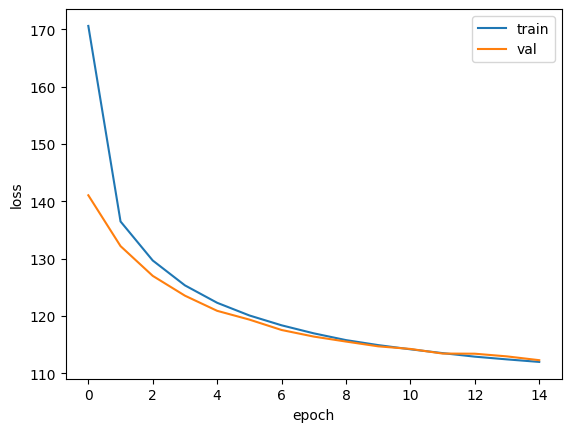

In [8]:
# Let's draw a learning curve like below.
plt.plot(train_history, label='train')
plt.plot(test_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Test

In [9]:
best_model.eval()
with torch.no_grad():
  running_loss = 0
  for input, label in test_dataloader:
    input = input.to(device)
    output, mu, var = best_model(input)
    loss = loss_func(input, output, mu, var)
    running_loss += loss.item()

  test_loss = running_loss / len(test_dataloader.dataset)
  print(test_loss)

111.50179521484375


torch.Size([100, 784])


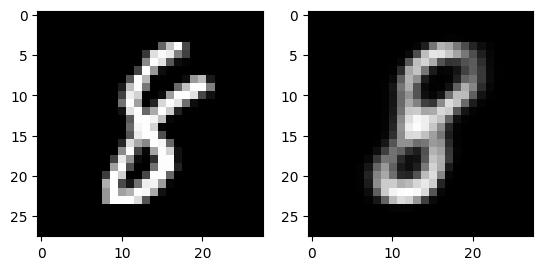

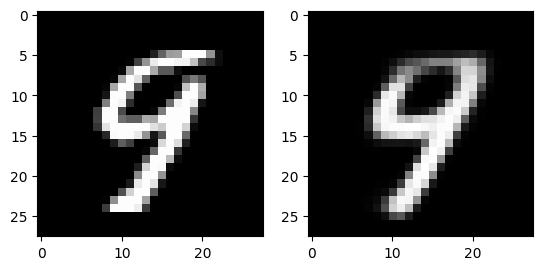

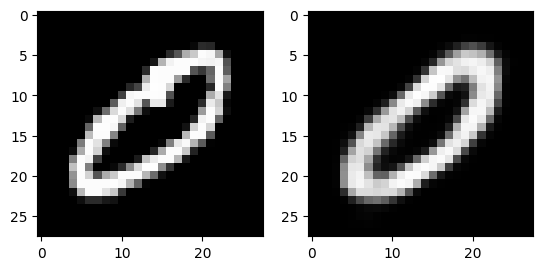

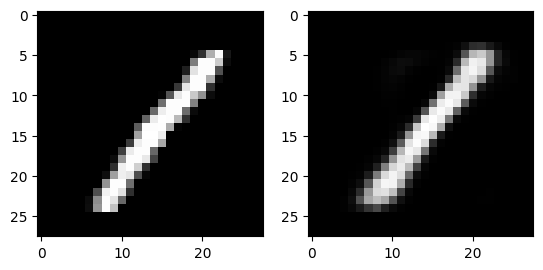

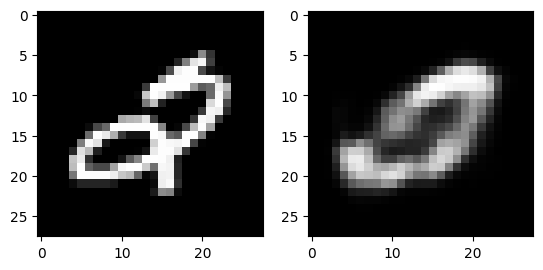

In [10]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(input[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()